In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [55]:

# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1582961 sha256=8ef9cb8c40dd32fce7c8c7218a5e6bdf24cd8cabc82e77f276c730a69c51f3af
  Stored in directory: /tmp/pip-ephem-wheel-cache-b84gszv6/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection
  Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [56]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
import cv2
import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

In [57]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

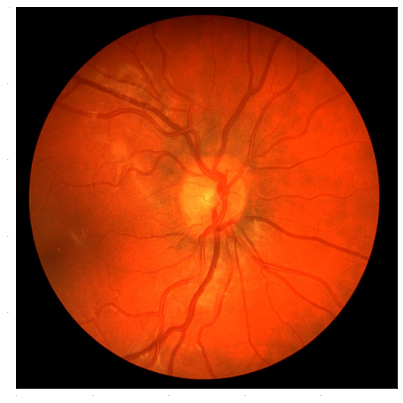

In [69]:
# Load images and visualize
#train_image_dir = 'models/research/object_detection/test_images/ducky/train/*.*'
train_image_dir = r"/content/drive/My Drive/retina/detection/*.*"
files = glob.glob(train_image_dir)


train_images_np = []

for i in range(40):
    img = cv2.imread(files[i])
    #print(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #if img.shape[0] == 400 and img.shape[1] == 400:
    #print(img.shape)
    img = cv2.resize(img,(500,500),interpolation = cv2.INTER_CUBIC)
    train_images_np.append(img)

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

'''for idx, train_image_np in enumerate(train_images_np):
  plt.subplot(2, 3, idx+1)
  plt.imshow(train_image_np)
plt.show()'''
t = len(train_images_np)

train_images_np = np.array(train_images_np)
#train_images_np = train_images_np.reshape((t,100,100,3))
train_images_np.shape
plt.imshow(train_images_np[0]);

In [70]:
print(t)

40


In [71]:
gt_boxes = []

colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [72]:
# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
duck_class_id = 1
num_classes = 1

category_index = {duck_class_id: {'id': duck_class_id, 'name': 'Eye ball'}}

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')

Done prepping data.


In [75]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2020-10-22 08:22:32--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.20.128, 2607:f8b0:400e:c07::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.20.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz.3’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   234MB/s    in 1.0s    

2020-10-22 08:22:33 (234 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz.3’ saved [244817203/244817203]

mv: cannot move 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint' to 'models/research/object_detection/test_data/checkpoint': Directory not empty


In [76]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


In [77]:
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 4
learning_rate = 0.01
num_batches = 600

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

losses = []

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)
  losses.append(total_loss)
  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!
batch 0 of 600, loss=1.5226471
batch 10 of 600, loss=0.7202019
batch 20 of 600, loss=0.44876504
batch 30 of 600, loss=0.5540288
batch 40 of 600, loss=0.43600485
batch 50 of 600, loss=0.38503
batch 60 of 600, loss=0.6778996
batch 70 of 600, loss=0.21550786
batch 80 of 600, loss=0.27515924
batch 90 of 600, loss=0.33707625
batch 100 of 600, loss=0.24288127
batch 110 of 600, loss=0.20567167
batch 120 of 600, loss=0.15330784
batch 130 of 600, loss=0.13555664
batch 140 of 600, loss=0.09890132
batch 150 of 600, loss=0.18327683
batch 160 of 600, loss=0.14477624
batch 170 of 600, loss=0.1235829
batch 180 of 600, loss=0.18401863
batch 190 of 600, loss=0.13050877
batch 200 of 600, loss=0.10819832
batch 210 of 600, loss=0.09930326
batch 220 of 600, loss=0.07019704
batch 230 of 600, loss=0.10886053
batch 240 of 600, loss=0.14279647
batch 250 of 600, loss=0.098730795
batch 260 of 600, loss=0.10556318
batch 270 of 600, loss=0.07204532
batch 280 of 600, loss=0.07949411
batch 290 of 

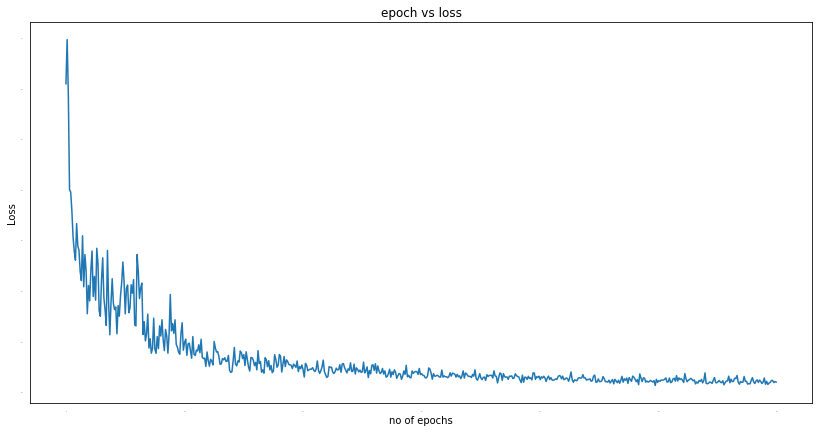

In [92]:
x = np.arange(0,600)
plt.plot(x,losses)
plt.title("epoch vs loss")
plt.ylabel("Loss")
plt.xlabel("no of epochs");

In [93]:
len(losses)

600

In [82]:
'''test_image_dir = 'models/research/object_detection/test_images/root/test/'
for i in range(1, 50):
  image_path = os.path.join(test_image_dir, 'out' + str(i) + '.jpg')
  test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))'''

test_images_np = []

for i in range(40,len(files)):
    img = cv2.imread(files[i])
    #print(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    #print(img.shape)
    img = cv2.resize(img,(500,500),interpolation = cv2.INTER_CUBIC)
    test_images_np.append(img)

#test_images_np =  train_images_np[40:90]
# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  print(preprocessed_image.shape)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  #print("hi")
  input_tensor = tf.reshape(input_tensor,(1,500,500,3))
  detections = detect(input_tensor)
  #print("ok")

  plot_detections(
      test_images_np[i],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(2, 2), image_name= r"/content/drive/My Drive/retina/results/gif_frame_" + ('%02d' % i) + ".jpg")

(1, 640, 640, 3)


In [83]:
'''detection_train = detections.copy()
#detection_train['detection_scores'][0] = 100
for i in range()
type(detection_train)'''

"detection_train = detections.copy()\n#detection_train['detection_scores'][0] = 100\nfor i in range()\ntype(detection_train)"

In [84]:


'''for i in range(len(train_images_np)):
  plot_detections(
      train_images_np[i],
      gt_boxes[i],
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(2, 2), image_name= r"/content/drive/My Drive///train/train" + ('%02d' % i) + ".jpg")'''

'for i in range(len(train_images_np)):\n  plot_detections(\n      train_images_np[i],\n      gt_boxes[i],\n      detections[\'detection_classes\'][0].numpy().astype(np.uint32)\n      + label_id_offset,\n      detections[\'detection_scores\'][0].numpy(),\n      category_index, figsize=(2, 2), image_name= r"/content/drive/My Drive///train/train" + (\'%02d\' % i) + ".jpg")'

In [85]:
#detections['detection_boxes']

In [86]:
#filenames[1]

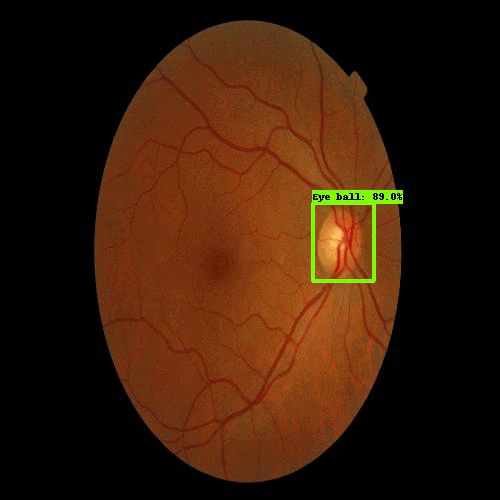

In [89]:
imageio.plugins.freeimage.download()

anim_file = r"/content/drive/My Drive/retina/eye ball.gif"

filenames = glob.glob(r"/content/drive/My Drive/retina/results/*.jpg")
filenames = sorted(filenames)
last = -1
images = []
for filename in filenames:
  image = imageio.imread(filename)
  images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=1)

display(IPyImage(open(anim_file, 'rb').read()))

In [ ]:
img = cv2.imread(r"/content/drive/My Drive/root count/1.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img = cv2.resize(img,(500,500))

In [ ]:
plt.imshow(img);

In [90]:

# save trained model : model.save()
model_directory = r"/content/drive/My Drive/retina/"
model_name = 'TF_2_2_colab_eye_ball_obj_detection'
model_dest = os.path.join(os.sep, model_directory, model_name)
tf.saved_model.save(detection_model, model_dest, signatures=None, options=None)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1de943c908>, TensorSpec(shape=(None, 80, 80, 512), dtype=tf.float32, name='image_features/0/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1de943c978>, TensorSpec(shape=(None, 40, 40, 1024), dtype=tf.float32, name='image_features/1/1')), (<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1de943cc88>, TensorSpec(shape=(None, 20, 20, 2048), dtype=tf.float32, name='image_features/2/1'))], True), {}).
INFO:tensorflow:Unsupported signature for serialization: (([(<tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1de93ef2e8>, TensorSpec(shape=(None, 80, 80, 512), dt

In [ ]:
gt_box

In [ ]:
files[:20]